In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from devito import Function, configuration, norm, mmax, mmin, Operator, Eq, Min, Max

from examples.seismic import (
    demo_model, 
    AcquisitionGeometry, 
    Receiver,
    plot_velocity, 
    plot_perturbation, 
    plot_shotrecord,
    plot_image
)
from examples.seismic.acoustic import AcousticWaveSolver

configuration['log-level'] = 'WARNING'

In [2]:
nshots = 9  # Number of shots to used to generate the gradient
nreceivers = 101  # Number of receiver locations per shot 
fwi_iterations = 5  # Number of outer FWI iterations

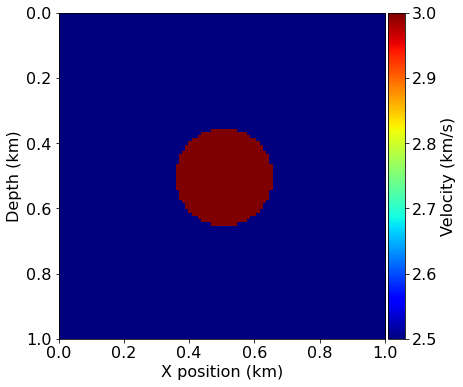

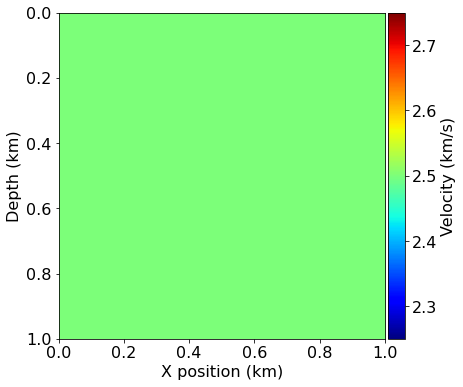

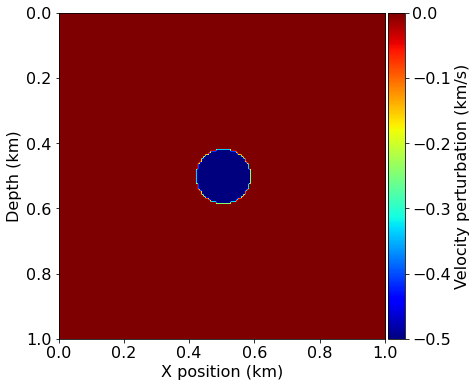

In [3]:
## Define true and initial model
# use the "true" model to generate our synthetic shot data and 
# use a "smooth" model as our initial guess

shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # Need origin to define relative source and receiver locations

model = demo_model('circle-isotropic', vp_circle=3.0, vp_background=2.5,
                    origin=origin, shape=shape, spacing=spacing, nbl=40)

model0 = demo_model('circle-isotropic', vp_circle=2.5, vp_background=2.5,
                     origin=origin, shape=shape, spacing=spacing, nbl=40,
                    grid = model.grid)

plot_velocity(model)
plot_velocity(model0)
plot_perturbation(model0, model)

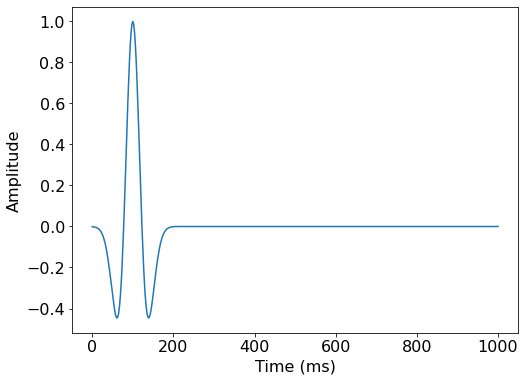

In [4]:
# Define acquisition geometry: source
t0 = 0.
tn = 1000. 
f0 = 0.010
# Position the source:
src_coordinates = np.empty((1, 2))
src_coordinates[0, 1] = np.array(model.domain_size[1]) * .5
src_coordinates[0, 0] = 20.

# Define acquisition geometry: receivers

# Initialize receivers for synthetic and imaging data
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 1] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coordinates[:, 0] = 980.

# Geometry

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates,
                               t0, tn, f0=f0, src_type='Ricker')
# We can plot the time signature to see the wavelet
geometry.src.show()

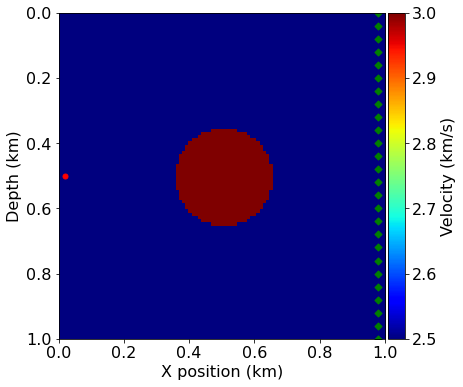

In [5]:
# Plot acquisition geometry
plot_velocity(model, source=geometry.src_positions,
              receiver=geometry.rec_positions[::4, :])

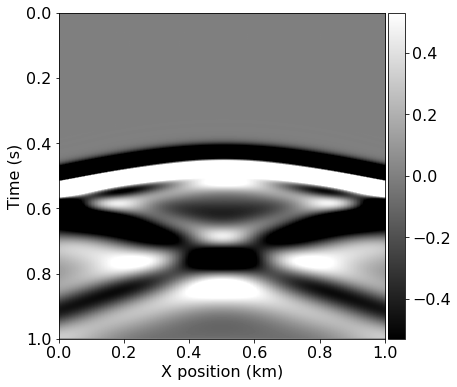

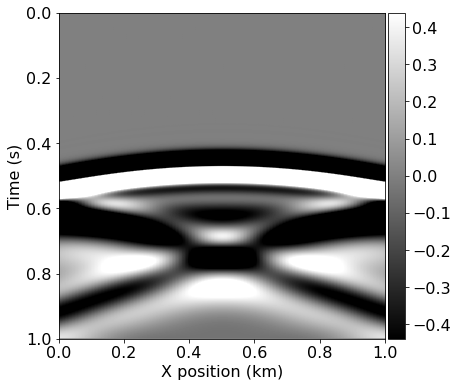

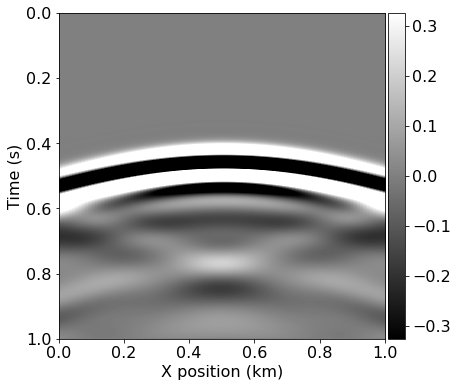

In [6]:
solver = AcousticWaveSolver(model, geometry, space_order=4)

# Compute synthetic data with forward operator 
true_d, _, _ = solver.forward(vp=model.vp)
# Compute initial data with forward operator 
smooth_d, _, _ = solver.forward(vp=model0.vp)

# Plot shot record for true and smooth velocity model and the difference
plot_shotrecord(true_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn)

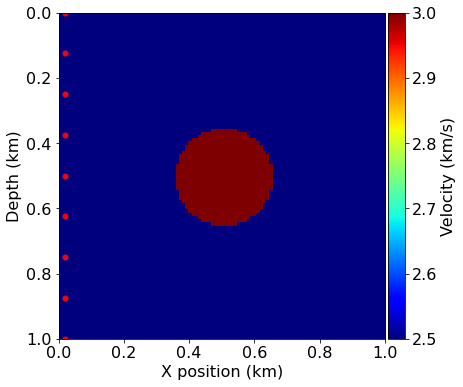

In [7]:
# Prepare the varying source locations
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = 20.
source_locations[:, 1] = np.linspace(0., 1000, num=nshots)

plot_velocity(model, source=source_locations)

In [8]:
def fwi_gradient(vp_in):    
    # Create symbols to hold the gradient and residual
    grad = Function(name="grad", grid=model.grid)
    residual = Receiver(name='rec', grid=model.grid,
            time_range=geometry.time_axis, 
            coordinates=geometry.rec_positions)
        
    objective = 0.
    for i in range(nshots):      
        # Update source location
        solver.geometry.src_positions[0, :] = source_locations[i, :]
        
        # Generate synthetic data from true model
        true_d, _, _ = solver.forward(vp=model.vp)
        
        # Compute smooth data and full forward wavefield u0
        smooth_d, u0, _ = solver.forward(vp=vp_in, save=True)
        
        # Compute gradient from data residual and update objective function 
        residual.data[:] = smooth_d.data[:] - true_d.data[:]
        
        objective += .5*norm(residual)**2
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
#         solver.jacobian_adjoint(rec=residual, u=u0, vp=vp_in, grad=grad)
    
    return objective, grad

In [9]:
# Compute gradient of initial model
ff, update = fwi_gradient(model0.vp)
print(ff, mmin(update), mmax(update))
assert np.isclose(ff, 39113, atol=1e1, rtol=0)
assert np.isclose(mmin(update), -821, atol=1e1, rtol=0)
assert np.isclose(mmax(update), 2442, atol=1e1, rtol=0)

39113.719475898426 -821.8776245117188 2442.593017578125


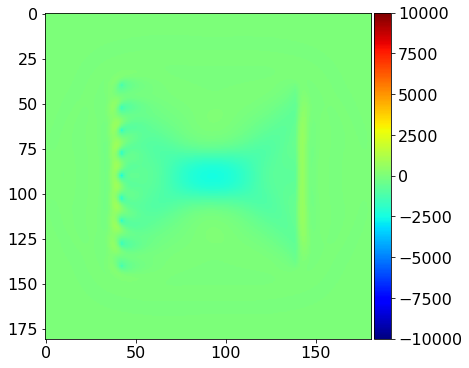

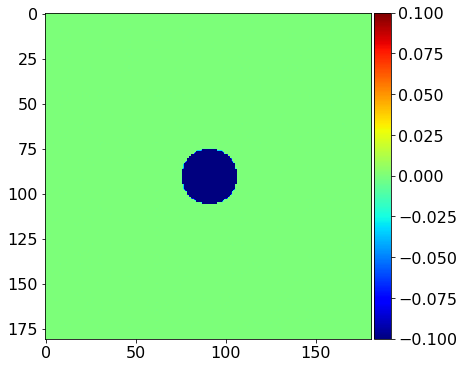

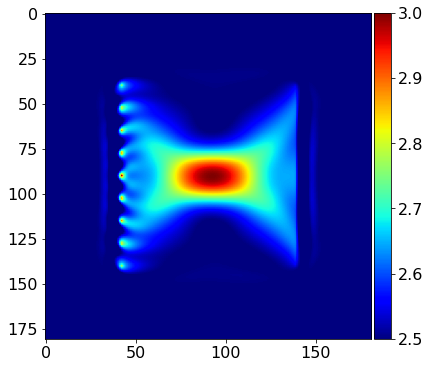

In [10]:
# Plot the FWI gradient
plot_image(-update.data, vmin=-1e4, vmax=1e4, cmap="jet")

# Plot the difference between the true and initial model.
# This is not known in practice as only the initial model is provided.
plot_image(model0.vp.data - model.vp.data, vmin=-1e-1, vmax=1e-1, cmap="jet")

# Show what the update does to the model
alpha = 0.5 / mmax(update)
plot_image(model0.vp.data + alpha*update.data, vmin=2.5, vmax=3.0, cmap="jet")

In [11]:
# Define bounding box constraints on the solution.
def update_with_box(vp, alpha, dm, vmin=2.0, vmax=3.5):
    update = vp + alpha * dm
    update_eq = Eq(vp, Max(Min(update, vmax), vmin))
    Operator(update_eq)()

In [12]:
# Run FWI with gradient descent
history = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
    # Compute the functional value and gradient for the current
    # model estimate
    phi, direction = fwi_gradient(model0.vp)
    
    # Store the history of the functional values
    history[i] = phi
    
    # Artificial Step length for gradient descent
    # In practice this would be replaced by a Linesearch (Wolfe, ...)
    # that would guarantee functional decrease Phi(m-alpha g) <= epsilon Phi(m)
    # where epsilon is a minimum decrease constant
    alpha = .05 / mmax(direction)

    # Update the model estimate and enforce minimum/maximum values
    update_with_box(model0.vp, alpha, direction)
    
    # Log the progress made
    print('Objective value is %f at iteration %d' % (phi, i+1))

Objective value is 39113.713813 at iteration 1
Objective value is 24132.300688 at iteration 2
Objective value is 14098.792036 at iteration 3
Objective value is 7706.452702 at iteration 4
Objective value is 3828.810224 at iteration 5


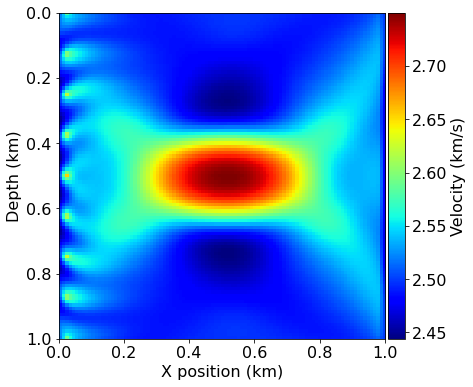

In [13]:
plot_velocity(model0)

In [14]:
assert np.isclose(history[-1], 3828, atol=1e1, rtol=0)

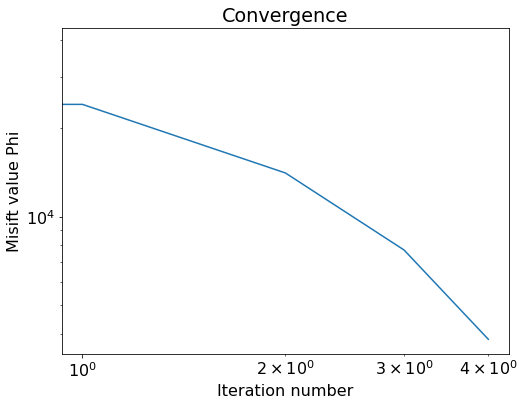

In [15]:
import matplotlib.pyplot as plt

# Plot objective function decrease
plt.figure()
plt.loglog(history)
plt.xlabel('Iteration number')
plt.ylabel('Misift value Phi')
plt.title('Convergence')
plt.show()